#  Обратное распространение ошибки

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* http://cs231n.stanford.edu/handouts/linear-backprop.pdf
* https://www.adityaagrawal.net/blog/deep_learning/bprop_fc
* https://en.wikipedia.org/wiki/Stochastic_gradient_descent

In [34]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
from IPython.display import clear_output

## Задачи для совместного разбора

1\. Реализуйте обратное распространение ошибки для модели нейрона с квадратичной функцией потерь при условии, что на вход нейрону поступает вектор `inputs`. Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`. 

In [35]:
class Neuron:
    def __init__(self, n_features: int, seed: int | None = None, grad: bool = False):
        """"
        n_features: количество входных признаков.
        seed: используется для инициализации генератора случайных чисел - потребуется для воспроизводимости.
        grad: булевый флаг, указывающий, нужно ли отслеживать градиенты для весов и смещения (нужен, чтобы задействовать autograd при необходимости).
        """
        if seed is not None:
            th.manual_seed(seed)
        self.weights = th.randn(n_features, requires_grad=grad)
        self.bias = th.randn(1, requires_grad=grad)

    def forward(self, inputs: th.Tensor) -> th.Tensor:
        """
        Реализация прямого прохода
        inputs: (feats, )
        returns: scalar
        """
        return inputs @ self.weights + self.bias

    def backward(self, inputs: th.Tensor, dnext: th.Tensor) -> None:
        """
        inputs: входные данные, которые были переданы в forward.
        dnext: градиент ошибки, полученный от следующего слоя (или выходного значения).
        """
        self.dweights = dnext * inputs # градиент по весам (без смещения)
        self.dinput = dnext * self.weights # градиент по входам
        self.dbias = dnext # градиент по смещению

In [36]:
class Loss:
    def forward(self, y_pred: th.Tensor, y_true: th.Tensor) -> th.Tensor:
        """
        Реализация MSE Loss
        y_pred: scalar - "прогноз" модели
        y_true: scalar - правильный ответ
        returns: scalar
        """
        return (y_pred - y_true) ** 2

    def backward(self, y_pred: th.Tensor, y_true: th.Tensor) -> None:
        """
        y_pred: scalar - "прогноз" модели
        y_true: scalar - правильный ответ
        """
        self.dinput = 2 * (y_pred - y_true)

In [37]:
# Создаем нейрон и функцию потерь
neuron = Neuron(n_features=2, seed=42)
criterion = Loss()
                
# один пример для теста
# обратите внимание, что тут нет размерности для батча (в реальных задачах - почти всегда будет)
x = th.tensor([2.0, 3.0])
y = th.tensor(10)

# прямой проход
y_pred = neuron.forward(x)
loss = criterion.forward(y_pred, y)
loss

tensor([75.7897])

In [38]:
# начинаем "раскручивать" градиенты назад
# сначала находим dl/dpred
criterion.backward(y_pred, y)
print(criterion.dinput)

tensor([-17.4115])


In [39]:
# потом находим dpred/dinput, dpred/dbias, dpred/dweights
# чтобы их рассчитать, нам нужен dl/dpred!
neuron.backward(x, criterion.dinput)
print(neuron.dweights, neuron.dbias, neuron.dinput)

tensor([-34.8229, -52.2344]) tensor([-17.4115]) tensor([-5.8623, -2.2428])


In [40]:
# теперь попросим torch рассчитать градиенты функции потерь по тензора-"участникам" графа вычислений 
neuron = Neuron(n_features=2, seed=42, grad=True)
criterion = Loss()
                
x = th.tensor([2.0, 3.0], requires_grad=True)
y = th.tensor(10)

# вы выполняете какие-то операции над тензорами ...
y_pred = neuron.forward(x)
# и получаете число - в данном случае значение функции потерь
loss = criterion.forward(y_pred, y)
# у этого "тензора-числа" можете вызвать метод backward, после чего
# torch рассчитает нужные градиенты
loss.backward()

# backward не обязательно вызывать у скаляров, но в противном случае
# требуется передать еще один аргумент (оставим пока это за рамками, сейчас не потребуется)

In [41]:
neuron.weights.grad, neuron.bias.grad, x.grad

(tensor([-34.8229, -52.2344]), tensor([-17.4115]), tensor([-5.8623, -2.2428]))

2\. Настройте модель нейрона, используя метод стохастического градиентного спуска и собственную реализацию обратного распространения ошибки.

In [42]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y)

In [43]:
# создаем слои
# помним, что они инициализируются случайным образом
neuron = Neuron(X.size(1))
criterion = Loss()

# скорость обучения
lr = 0.1

for epoch in range(10):
    losses = []
    # "стохастический" = "оцениваем градиент на одном примере"
    for x_example, y_example in zip(X, y):
        y_pred = neuron.forward(x_example)
        l = criterion.forward(y_pred, y_example)
        losses.append(l)

        # аналогично тому, что было выше
        criterion.backward(y_pred, y_example)
        neuron.backward(x_example, criterion.dinput)

        # шаг градиентного спуска
        neuron.weights -= lr * neuron.dweights
        neuron.bias -= lr * neuron.dbias
    print(f'epoch {epoch} mean loss {np.mean(losses)}')

epoch 0 mean loss 621.7234497070312
epoch 1 mean loss 8.010916644707322e-05
epoch 2 mean loss 7.045546090989063e-11
epoch 3 mean loss 1.1392611853899837e-10
epoch 4 mean loss 7.265341800399838e-11
epoch 5 mean loss 6.890516629498578e-11
epoch 6 mean loss 7.513040883866395e-11
epoch 7 mean loss 1.1443748726414071e-10
epoch 8 mean loss 1.191939047462398e-10
epoch 9 mean loss 9.104987597208236e-11


## Задачи для самостоятельного решения

In [44]:
SEED = 42
N_FEATURES = 3
BATCH_SIZE = 16
N_NEURONS = 3
LEARNING_RATE = 0.1
N_EPOCHS = 20

<p class="task" id="1"></p>

1\. Реализуйте обратное распространение ошибки для модели нейрона с функцией потерь MSE при условии, что на вход нейрону поступает пакет (двумерный тензор) `inputs`. Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`. 

$$\mathbf{X} = \begin{bmatrix}
x_{10} & x_{11} & \ldots & x_{1m} \\
x_{20} & x_{21} & \ldots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{k0} & x_{k1} & \ldots & x_{km} \\
\end{bmatrix}
\mathbf{Y} = \begin{bmatrix}
y_{1} \\
y_{2} \\
\vdots \\
y_{k} \\
\end{bmatrix}
\mathbf{W} = \begin{bmatrix}
w_{0} \\
w_{1} \\
\vdots \\
w_{m} \\
\end{bmatrix}$$

$$\hat{\mathbf{Y}} = \mathbf{X}\times \mathbf{W}$$

$$L = \frac{1}{k}\sum_{k}{(\hat{y_k}-y_k)^2}$$

$$\nabla_{\hat{\mathbf{Y}}} L=\begin{bmatrix}
\frac{\partial L}{\partial \hat{y_1}} \\
\frac{\partial L}{\partial \hat{y_2}} \\
\vdots \\
\frac{\partial L}{\partial \hat{y_k}} \\
\end{bmatrix} = \frac{2}{k}\begin{bmatrix}
\hat{y_1} - y_1 \\
\hat{y_2} - y_2 \\
\vdots \\
\hat{y_k} - y_k \\
\end{bmatrix}$$

$$\boldsymbol{\nabla_{\mathbf{W}} L = \mathbf{X}^T\nabla_{\hat{\mathbf{Y}}} L}$$

- [ ] Проверено на семинаре

In [45]:
class NeuronBatch:
    def __init__(self, n_features: int, seed: int | None = None, grad: bool = False):
        if seed is not None:
            th.manual_seed(seed)
        # Добавьте дополнительный вес для сдвига (bias) в виде столбца - этот трюк поможет меньше посчитать все нужные градиенты по весам в одну операцию
        # задайте requires_grad у этого тензора, чтобы иметь возможность протестировать
        # автоматическое дифференцирование от torch
        self.weights : th.Tensor = th.randn(n_features + 1,1)
        self.dweights = None

    def add_ones_col(self, inputs: th.Tensor) -> th.Tensor:
        """
        Добавляет столбец из единиц в начало матрицы inputs
        inputs: ("batch", "n_features")
        returns: ("batch", "n_features+1")
        """

        return th.cat((th.ones(inputs.shape[0],1),inputs), dim=1)
        
    def forward(self, inputs: th.Tensor) -> th.Tensor:
        """
        inputs: ("batch", "n_features")
        returns: ("batch", 1)
        """
        return self.add_ones_col(inputs) @ self.weights

    def backward(self, inputs: th.Tensor, dnext: th.Tensor) -> None:
        """
        inputs: ("batch", "n_features")
        dnext: ("batch", 1)
        """
        self.dweights = self.add_ones_col(inputs).mT @ dnext # ("batch", "n_features+1")

In [46]:
class MSELoss:
    """ Ручная реализация среднеквадратичной ошибки """
    def __init__(self):
        self.dinput = None

    def forward(self, y_pred: th.Tensor, y_true: th.Tensor) -> th.Tensor:
        return (y_pred - y_true).pow(2).mean()

    def backward(self, y_pred: th.Tensor, y_true: th.Tensor) -> None:
        """
        Вычисляет градиент функции потерь по y_pred.
        """
        batch_size = y_true.shape[0]
        
        # ИСПРАВЛЕНИЕ: Порядок вычитания должен быть (y_pred - y_true)
        self.dinput = 2.0 * (y_pred - y_true) / batch_size

In [47]:
th.manual_seed(SEED)
X_train = th.randn(BATCH_SIZE, N_FEATURES)
y_train = th.randn(BATCH_SIZE, 1)

In [48]:
neuron_manual = NeuronBatch(N_FEATURES, seed=SEED)
loss_fn_manual = MSELoss()

initial_weights_manual = neuron_manual.weights.clone()
print(f"Начальные веса (ручные):\n{initial_weights_manual.T}\n")

y_pred_manual = neuron_manual.forward(X_train)
loss_manual = loss_fn_manual.forward(y_pred_manual, y_train)
print(f"Потери (ручные): {loss_manual.item():.4f}")

loss_fn_manual.backward(y_pred_manual, y_train)
neuron_manual.backward(X_train, loss_fn_manual.dinput)
print(f"Градиент по весам (ручной):\n{neuron_manual.dweights.T}\n")

neuron_manual.weights -= LEARNING_RATE * neuron_manual.dweights
print(f"Обновленные веса (ручные):\n{neuron_manual.weights.T}\n")

print("Итоговые ручные веса:", neuron_manual.weights.T)

Начальные веса (ручные):
tensor([[0.3367, 0.1288, 0.2345, 0.2303]])

Потери (ручные): 1.2959
Градиент по весам (ручной):
tensor([[0.7752, 0.5772, 1.4549, 0.3140]])

Обновленные веса (ручные):
tensor([[0.2592, 0.0711, 0.0890, 0.1989]])

Итоговые ручные веса: tensor([[0.2592, 0.0711, 0.0890, 0.1989]])


In [49]:
model_torch = nn.Linear(N_FEATURES, 1)
loss_fn_torch = nn.MSELoss()

with th.no_grad():
    model_torch.bias.copy_(initial_weights_manual[0])
    model_torch.weight.copy_(initial_weights_manual[1:].T)

print(f"Начальные веса (PyTorch) - Bias:\n{model_torch.bias.data}, Weights: {model_torch.weight.data}\n")

optimizer = th.optim.SGD(model_torch.parameters(), lr=LEARNING_RATE)

y_pred_torch = model_torch(X_train)
loss_torch = loss_fn_torch(y_pred_torch, y_train)
print(f"Потери (PyTorch): {loss_torch.item():.4f}")

optimizer.zero_grad() 
loss_torch.backward()
grad_bias_torch = model_torch.bias.grad
grad_weights_torch = model_torch.weight.grad
print(f"Градиент по весам (PyTorch) - d_Bias:\n{grad_bias_torch}, d_Weights: {grad_weights_torch}\n")


optimizer.step()
final_bias_torch = model_torch.bias.data
final_weights_torch = model_torch.weight.data
print(f"Обновленные веса (PyTorch) - Bias:\n{final_bias_torch}, Weights: {final_weights_torch}\n")


final_weights_torch_combined = th.cat([final_bias_torch.unsqueeze(1), final_weights_torch.T])

print("Итоговые веса PyTorch:", final_weights_torch_combined.T)

Начальные веса (PyTorch) - Bias:
tensor([0.3367]), Weights: tensor([[0.1288, 0.2345, 0.2303]])

Потери (PyTorch): 1.2959
Градиент по весам (PyTorch) - d_Bias:
tensor([0.7752]), d_Weights: tensor([[0.5772, 1.4549, 0.3140]])

Обновленные веса (PyTorch) - Bias:
tensor([0.2592]), Weights: tensor([[0.0711, 0.0890, 0.1989]])

Итоговые веса PyTorch: tensor([[0.2592, 0.0711, 0.0890, 0.1989]])


In [50]:
assert th.allclose(loss_manual, loss_torch)
assert th.allclose(neuron_manual.weights, final_weights_torch_combined)
print('Реализация корректна')

Реализация корректна


<p class="task" id="2"></p>

2\. Настройте модель нейрона, используя метод мини-пакетного градиентного спуска. 

Используйте обратное распространение ошибки, реализованное самостоятельно. Выведите на экран полученные и правильные коэффициенты модели.

- [ ] Проверено на семинаре

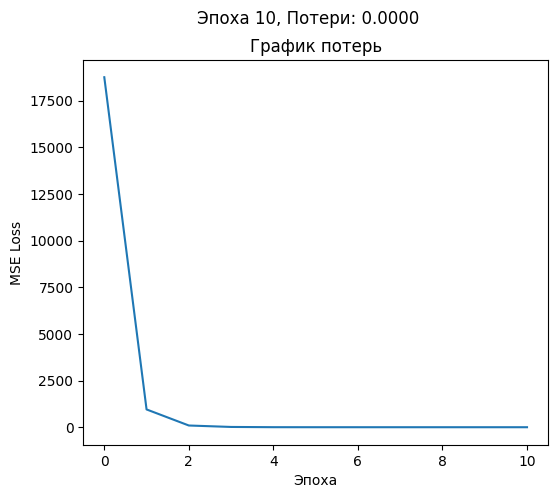

Полученные коэффициенты: [ 0.5  75.06 28.2  17.74]
Правильные коэффициенты: [ 0.5  75.06 28.2  17.74]


In [51]:
X, y, coef = make_regression(n_features=N_FEATURES, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
N_EPOCHS = 10
neuron = NeuronBatch(n_features=N_FEATURES, seed=13)
loss_fn = MSELoss()
losses = []

for epoch in range(N_EPOCHS+1):
    epoch_loss = 0.0
    for X_batch, y_batch in dataloader:
        
        y_pred = neuron.forward(X_batch)
        loss = loss_fn.forward(y_pred, y_batch)
        epoch_loss += loss.item()
        
        loss_fn.backward(y_pred, y_batch)
        neuron.backward(X_batch, loss_fn.dinput)  
        with th.no_grad():
            neuron.weights -= LEARNING_RATE * neuron.dweights
            

    losses.append(epoch_loss)
    clear_output(wait=True)
        
    
    fig, ax1 = plt.subplots(1, figsize=(6, 5))

    ax1.plot(losses)
    ax1.set_title("График потерь")
    ax1.set_xlabel("Эпоха")
    ax1.set_ylabel("MSE Loss")

    
    fig.suptitle(f"Эпоха {epoch}, Потери: {epoch_loss:.4f}")
    
    plt.show()
    

learned_coeffs = neuron.weights.flatten()
true_coeffs = th.cat([th.tensor([0.5]), th.from_numpy(coef)])

print(f"Полученные коэффициенты: {learned_coeffs.numpy().round(2)}")
print(f"Правильные коэффициенты: {true_coeffs.numpy().round(2)}")

<p class="task" id="3"></p>

3\. Реализуйте обратное распространение ошибки для модели полносвязного слоя с функцией потерь MSE при условии, что на вход нейрону поступает пакет (двумерный тензор) `inputs`.  Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`. 

Обратите внимание, что вам потребуются оба градиента $ \boldsymbol{\nabla_{\mathbf{W}} L }$ и $\boldsymbol{\nabla_{\mathbf{X}} L}$ для распространения ошибки с несколькими слоями.

$$\mathbf{X} = \begin{bmatrix}
x_{10} & x_{11} & \ldots & x_{1m} \\
x_{20} & x_{21} & \ldots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{k0} & x_{k1} & \ldots & x_{km} \\
\end{bmatrix}
\mathbf{Y} = \begin{bmatrix}
y_{1} \\
y_{2} \\
\vdots \\
y_{k} \\
\end{bmatrix}
\mathbf{W} = \begin{bmatrix}
w_{01} & w_{02} & \ldots & w_{0n} \\
w_{11} & w_{12} & \ldots & w_{1n} \\
\vdots & \vdots & \ddots & \vdots \\
w_{m1} & w_{m2} & \ldots & w_{mn} \\
\end{bmatrix}$$

$$\hat{\mathbf{Y}} = \mathbf{X}\times \mathbf{W}$$

$$\nabla_{\hat{\mathbf{Y}}} L = \begin{bmatrix}
\frac{\partial L}{\partial \hat{y_{11}}} & \ldots & \frac{\partial L}{\partial \hat{y_{1n}}} \\
\vdots & \vdots & \vdots \\
\frac{\partial L}{\partial \hat{y_{k1}}} & \ldots & \frac{\partial L}{\partial \hat{y_{kn}}} \\
\end{bmatrix}$$

$$\boldsymbol{\nabla_{\mathbf{W}} L = \mathbf{X}^T\times \nabla_{\hat{\mathbf{Y}}} L}$$
$$\boldsymbol{\nabla_{\mathbf{X}} L = \nabla_{\hat{\mathbf{Y}}} L\times \mathbf{W}^T}$$

- [ ] Проверено на семинаре

In [52]:
class Linear:
    def __init__(self, n_features: int, n_neurons: int, seed: int | None = None, grad: bool = False):
        if seed is not None:
            th.manual_seed(seed)
        # Добавьте дополнительный вес для сдвига
        # задайте requires_grad у этого тензора, чтобы иметь возможность протестировать
        # автоматическое дифференцирование от torch
        self.weights = th.randn(n_features+1, n_neurons, requires_grad=grad)

    def add_ones_col(self, inputs: th.Tensor) -> th.Tensor:
        """Добавляет столбец из единиц в начало матрицы inputs
        inputs: ("batch", "n_features")
        returns: ("batch", "n_features+1")
        """
        return th.cat((th.ones(inputs.shape[0],1),inputs), dim=1)
        
    def forward(self, inputs: th.Tensor) -> th.Tensor:
        """
        inputs: ("batch", "n_features")
        returns: ("batch", "n_neurons")
        """
        return self.add_ones_col(inputs) @ self.weights

    def backward(self, inputs: th.Tensor, dnext: th.Tensor):
        """
        inputs: ("batch", "n_features")
        dnext: ("batch", "n_neurons")
        """
        self.dweights = self.add_ones_col(inputs).T @ dnext
        self.dinput = (dnext @ self.weights.T)[:,1:]

In [53]:
class MSELoss:       
    def forward(self, y_pred: th.Tensor, y_true: th.Tensor) -> th.Tensor:
        """
        y_pred: ("batch", n_neurons)
        y_true: ("batch", n_neurons1)
        """
        return (y_pred - y_true).pow(2).mean()

    def backward(self, y_pred: th.Tensor, y_true: th.Tensor) -> None:
        """
        y_pred: ("batch", n_neurons)
        y_true: ("batch", n_neurons)
        """
        self.dinput = 2.0 * (y_pred - y_true) / y_true.numel()

Создаем случайные данные

In [54]:
X_train = th.randn(BATCH_SIZE, N_FEATURES)
y_train = th.randn(BATCH_SIZE, N_NEURONS)

Ручная реализация

In [55]:
layer_manual = Linear(N_FEATURES, N_NEURONS, seed=SEED)
loss_fn_manual = MSELoss()

initial_weights_manual = layer_manual.weights.clone()

y_pred_manual = layer_manual.forward(X_train)
loss_manual = loss_fn_manual.forward(y_pred_manual, y_train)
print(f"Потери (ручные): {loss_manual.item():.4f}")

loss_fn_manual.backward(y_pred_manual, y_train)
layer_manual.backward(X_train, loss_fn_manual.dinput)

print(f"Градиент по весам (ручной):\n{layer_manual.dweights}\n")
print(f"Градиент по входу (ручной):\n{layer_manual.dinput}\n")

Потери (ручные): 4.0648
Градиент по весам (ручной):
tensor([[ 0.4860,  0.0692,  0.5755],
        [ 0.2349, -0.7614, -0.2566],
        [ 1.7376, -0.3898,  0.5013],
        [ 0.9361, -0.1757,  0.7288]])

Градиент по входу (ручной):
tensor([[-0.0146, -0.4583, -0.1313],
        [-0.0295,  0.1928,  0.1173],
        [-0.0178, -0.2377, -0.0036],
        [ 0.0733,  0.3611,  0.0412],
        [ 0.0122,  0.0766,  0.0096],
        [-0.0260, -0.0672,  0.0295],
        [ 0.0206, -0.0156, -0.0417],
        [ 0.0548,  0.2307,  0.0144],
        [ 0.2359,  0.7718,  0.0818],
        [-0.0223,  0.0984,  0.0865],
        [-0.0216,  0.0526,  0.0311],
        [-0.1389,  0.1547,  0.2043],
        [-0.0743, -0.2531,  0.0173],
        [-0.1049,  0.0411,  0.0704],
        [-0.0553,  0.1001,  0.0719],
        [ 0.0354,  0.2467,  0.0341]])



Реализация PyTorch

In [56]:
X_train_torch = X_train.clone().requires_grad_(True) 

model_torch = nn.Linear(N_FEATURES, N_NEURONS)
loss_fn_torch = nn.MSELoss()

with th.no_grad():
    model_torch.bias.copy_(initial_weights_manual[0, :])
    model_torch.weight.copy_(initial_weights_manual[1:, :].T)
    
y_pred_torch = model_torch(X_train_torch)
loss_torch = loss_fn_torch(y_pred_torch, y_train)
print(f"Потери (PyTorch): {loss_torch.item():.4f}")

loss_torch.backward()

grad_weights_torch = model_torch.weight.grad.T # Транспонируем для совпадения формы
grad_bias_torch = model_torch.bias.grad
grad_input_torch = X_train_torch.grad

grad_combined_torch = th.cat([grad_bias_torch.unsqueeze(0), grad_weights_torch], dim=0)

print(f"Градиент по весам (PyTorch):\n{grad_combined_torch}\n")
print(f"Градиент по входу (PyTorch):\n{grad_input_torch}\n")

Потери (PyTorch): 4.0648
Градиент по весам (PyTorch):
tensor([[ 0.4860,  0.0692,  0.5755],
        [ 0.2349, -0.7614, -0.2566],
        [ 1.7376, -0.3898,  0.5013],
        [ 0.9361, -0.1757,  0.7288]])

Градиент по входу (PyTorch):
tensor([[-0.0146, -0.4583, -0.1313],
        [-0.0295,  0.1928,  0.1173],
        [-0.0178, -0.2377, -0.0036],
        [ 0.0733,  0.3611,  0.0412],
        [ 0.0122,  0.0766,  0.0096],
        [-0.0260, -0.0672,  0.0295],
        [ 0.0206, -0.0156, -0.0417],
        [ 0.0548,  0.2307,  0.0144],
        [ 0.2359,  0.7718,  0.0818],
        [-0.0223,  0.0984,  0.0865],
        [-0.0216,  0.0526,  0.0311],
        [-0.1389,  0.1547,  0.2043],
        [-0.0743, -0.2531,  0.0173],
        [-0.1049,  0.0411,  0.0704],
        [-0.0553,  0.1001,  0.0719],
        [ 0.0354,  0.2467,  0.0341]])



Проверим через функции "похожести" ответов

In [57]:
assert th.allclose(loss_manual, loss_torch)
assert th.allclose(layer_manual.dweights, grad_combined_torch)
assert th.allclose(layer_manual.dinput, grad_input_torch)
print("Реализация корректна")

Реализация корректна


<p class="task" id="4"></p>

4\. Настройте полносвязный слой, используя метод пакетного градиентного спуска. Используйте обратное распространение ошибки, реализованное самостоятельно. Выведите на экран полученные и правильные коэффициенты модели.

- [ ] Проверено на семинаре

Эпоха 60, Потери: 0.0001


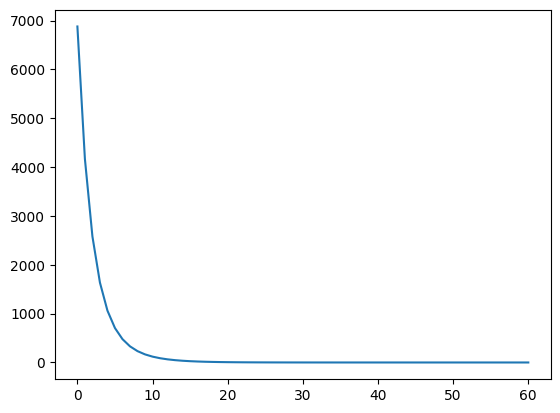


Полученные коэффициенты: [ 0.5  75.06 28.19 17.74]
Правильные коэффициенты: [ 0.5  75.06 28.2  17.74]


In [58]:
X, y, coef = make_regression(n_features=N_FEATURES, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

layer = Linear(n_features=N_FEATURES, n_neurons=1, seed=SEED)
loss_fn = MSELoss()
N_EPOCHS = 60
losses = []

for epoch in range(N_EPOCHS+1):
    clear_output()
    y_pred = layer.forward(X)
    loss = loss_fn.forward(y_pred, y)
    losses.append(loss)

    
    if epoch % 10 == 0:
        print(f"Эпоха {epoch}, Потери: {loss.item():.4f}")
        plt.plot(losses)
        plt.show()
        
    loss_fn.backward(y_pred, y)
    layer.backward(X, loss_fn.dinput)
    
    with th.no_grad():
        layer.weights -= LEARNING_RATE * layer.dweights
    

learned_coeffs = layer.weights.flatten()
true_coeffs = th.cat([th.tensor([0.5]), th.from_numpy(coef)])


print(f"\nПолученные коэффициенты: {np.round(learned_coeffs.numpy(), 2)}")
print(f"Правильные коэффициенты: {np.round(true_coeffs.numpy(), 2)}")

In [59]:
assert th.allclose(th.tensor(learned_coeffs.numpy(),dtype=th.float64), true_coeffs, atol=1e-1)
print("полученные коэффициенты близки к правильным")

полученные коэффициенты близки к правильным


<p class="task" id="5"></p>

5\. Используя решения предыдущих задач, создайте нейросеть и решите задачу регрессии. При наличии корректно реализованных методов `backward` у `Linear` и `MSE` вы можете обобщить процедуру распространения ошибки на любое количество слоев. Реализуйте и обучите модель, состояющую из двух полносвязных слоев:

1. Полносвязный слой с 10 нейронами;
2. Полносвязный слой с 1 нейроном;

Схематично процедура обратного распространения ошибки представлена на рис. ниже.

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).


- [ ] Проверено на семинаре

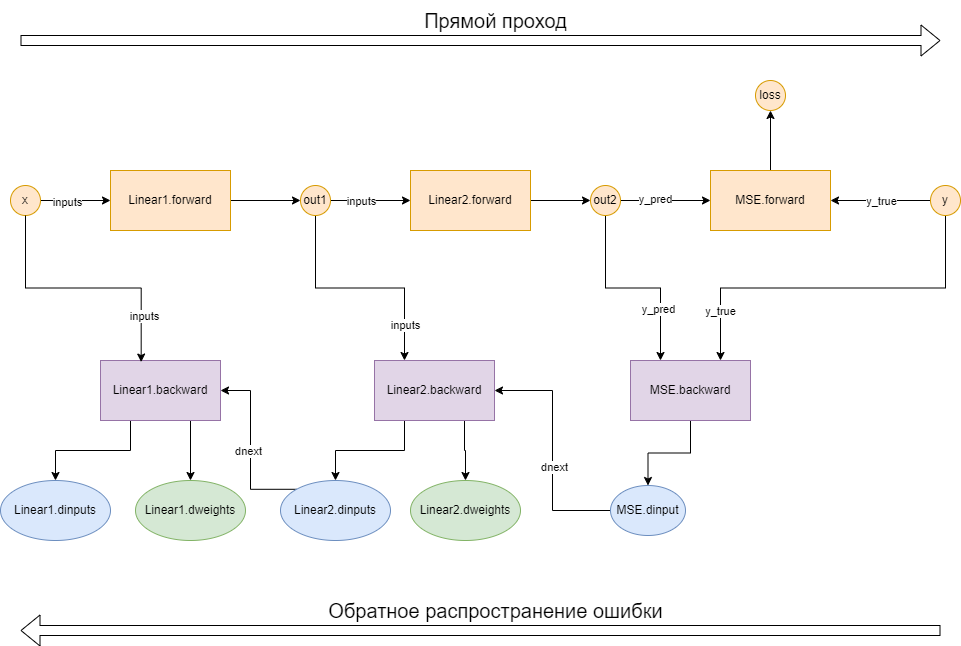

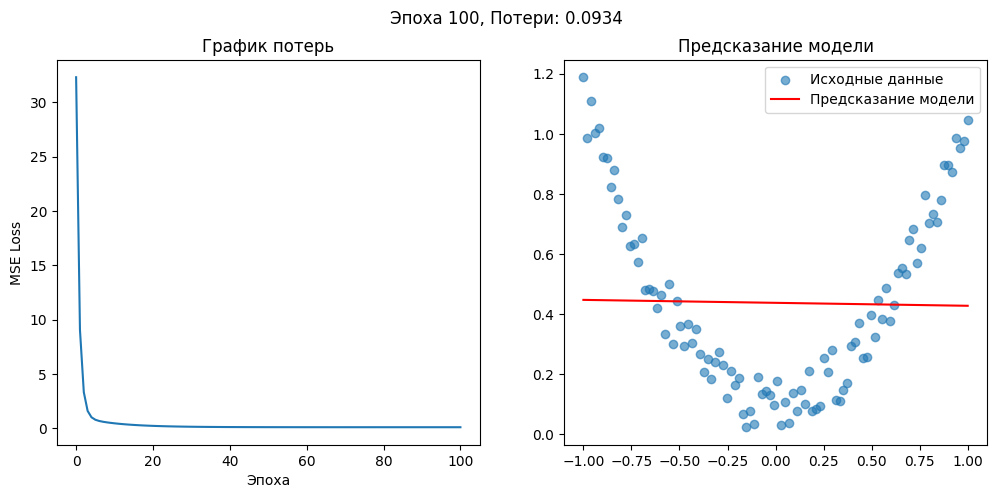

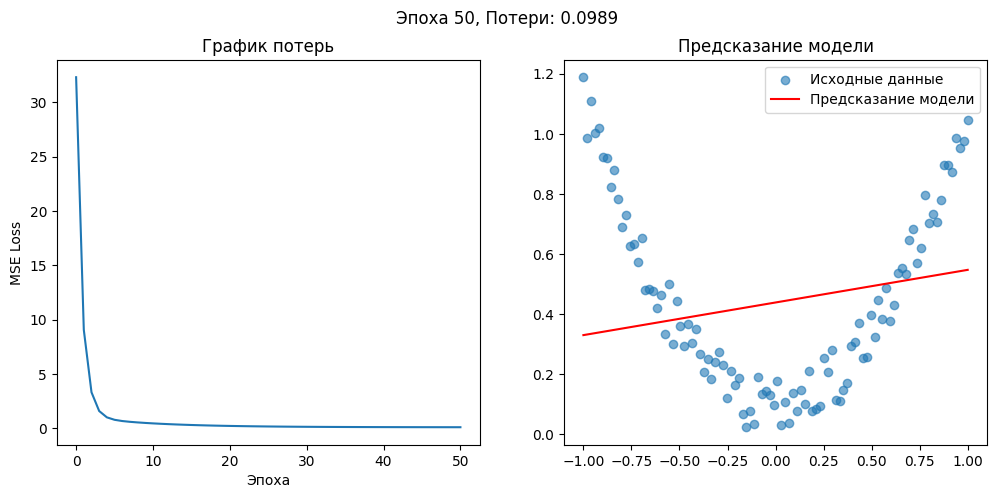

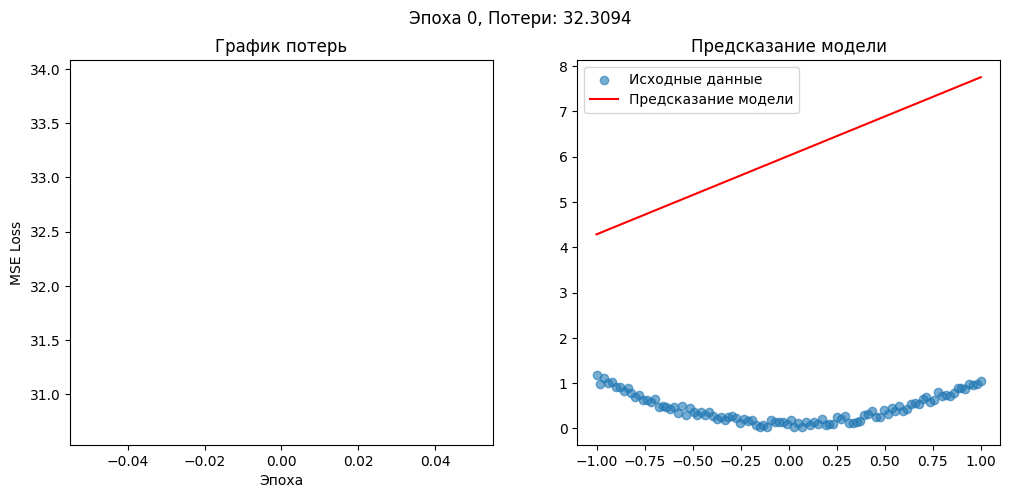

In [60]:
X = th.linspace(-1, 1, 100).view(-1, 1)
y = X.pow(2) + 0.2 * th.rand(X.size())

layer1 = Linear(n_features=1, n_neurons=10, seed=SEED)
layer2 = Linear(n_features=10, n_neurons=1, seed=SEED)
loss_fn = MSELoss()
LEARNING_RATE = 0.01
N_EPOCHS = 100
losses = []

for epoch in range(N_EPOCHS+1):
    
    out1 = layer1.forward(X)
    out2 = layer2.forward(out1)
    loss = loss_fn.forward(out2, y)
    losses.append(loss.item())
    
    loss_fn.backward(out2, y)
    layer2.backward(out1, loss_fn.dinput)
    layer1.backward(X, layer2.dinput)
    with th.no_grad():
        layer2.weights -= LEARNING_RATE * layer2.dweights
        layer1.weights -= LEARNING_RATE * layer1.dweights

    
    clear_output(wait=True)
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    if epoch == (N_EPOCHS+1)//2:
        mid_losses = losses.copy()
        mid_out2 = out2
        mid_epoch = epoch
    
    elif epoch == 0:
        start_losses = losses.copy()
        start_out2 = out2
        start_epoch = epoch
        
        
    ax1.plot(losses)
    ax1.set_title("График потерь")
    ax1.set_xlabel("Эпоха")
    ax1.set_ylabel("MSE Loss")

    ax2.scatter(X.numpy(), y.numpy(), label='Исходные данные', alpha=0.6)
    ax2.plot(X.numpy(), out2.detach().numpy(), color='red', label='Предсказание модели')
    ax2.set_title("Предсказание модели")
    ax2.legend()
    
    fig.suptitle(f"Эпоха {epoch}, Потери: {loss.item():.4f}")
    
    plt.show()
        

        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))    
    
ax1.plot(mid_losses)
ax1.set_title("График потерь")
ax1.set_xlabel("Эпоха")
ax1.set_ylabel("MSE Loss")

ax2.scatter(X.numpy(), y.numpy(), label='Исходные данные', alpha=0.6)
ax2.plot(X.numpy(), mid_out2.detach().numpy(), color='red', label='Предсказание модели')
ax2.set_title("Предсказание модели")
ax2.legend()

fig.suptitle(f"Эпоха {mid_epoch}, Потери: {mid_losses[-1]:.4f}")

plt.show()






fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))    
    
ax1.plot(start_losses)
ax1.set_title("График потерь")
ax1.set_xlabel("Эпоха")
ax1.set_ylabel("MSE Loss")

ax2.scatter(X.numpy(), y.numpy(), label='Исходные данные', alpha=0.6)
ax2.plot(X.numpy(), start_out2.detach().numpy(), color='red', label='Предсказание модели')
ax2.set_title("Предсказание модели")
ax2.legend()

fig.suptitle(f"Эпоха {start_epoch}, Потери: {start_losses[-1]:.4f}")

plt.show()

<p class="task" id="6"></p>

6\. Модель из предыдущей задачи является линейной и не способна качественно предсказать искомую зависимость. Для того, чтобы сделать модель нелинейной, в нейронных сетях используются функции активации. Для того, чтобы встроить такую функцию в процесс обратного распространения ошибки, необходимо реализовать соответствующий слой с методами `forward` и `backward`.

$$
f(x) = \max(0, x)
$$

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial f}\frac{\partial f}{\partial x} = \frac{\partial L}{\partial f}
\begin{cases} 
1 & \text{если } x \ge 0 \\
0 & \text{если } x <  0 
\end{cases}
$$

Здесь $L$ - это функция (слой), следующая за ReLU в потоке вычислений.

Реализуйте и обучите модель, состояющую из двух полносвязных слоев, разделенных функцией активации ReLU: 
1. Полносвязный слой с 10 нейронами
2. Активация ReLU
3. Полносвязный слой с 1 нейроном

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).




- [ ] Проверено на семинаре

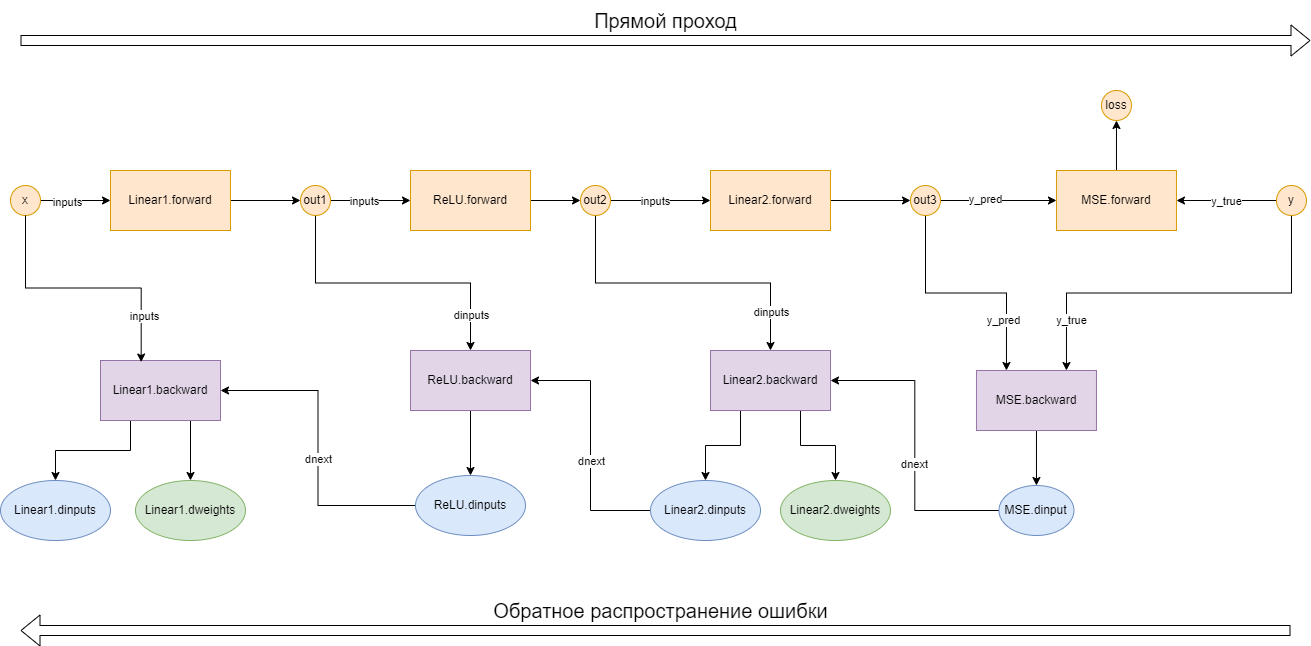

In [61]:
class ReLU:
    def forward(self, inputs: th.Tensor) -> th.Tensor:
        """
        inputs: ("batch", "n_features")
        returns: ("batch",n_features)
        """
        return th.maximum(inputs, th.zeros_like(inputs))

    def backward(
        self, 
        inputs: th.Tensor, 
        dvalues: th.Tensor
    ) -> th.Tensor:
        """
        inputs: ("batch", "n_features")
        dvalues: ("batch", "n_features")
        returns: ("batch", n_features)
        """
        self.dinput = dvalues.clone()
        self.dinput[inputs <= 0] = 0
        self.dnext = self.dinput

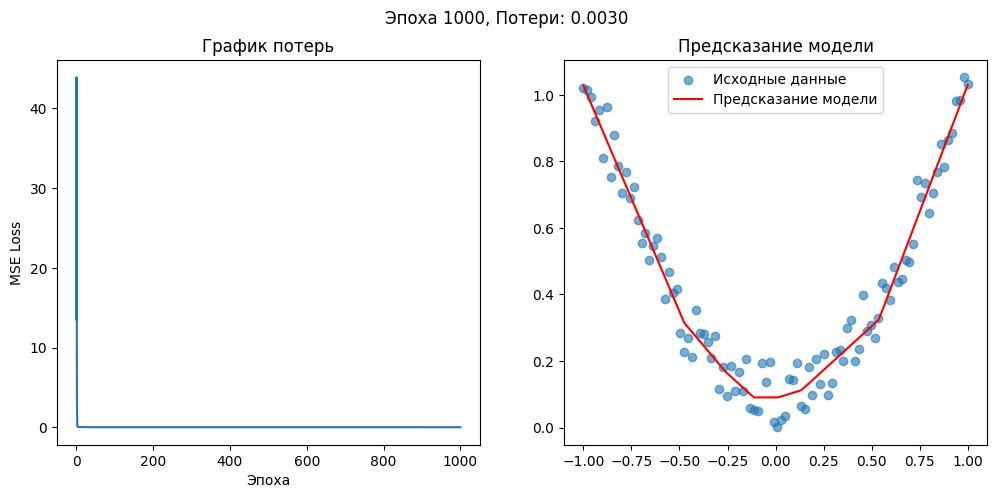

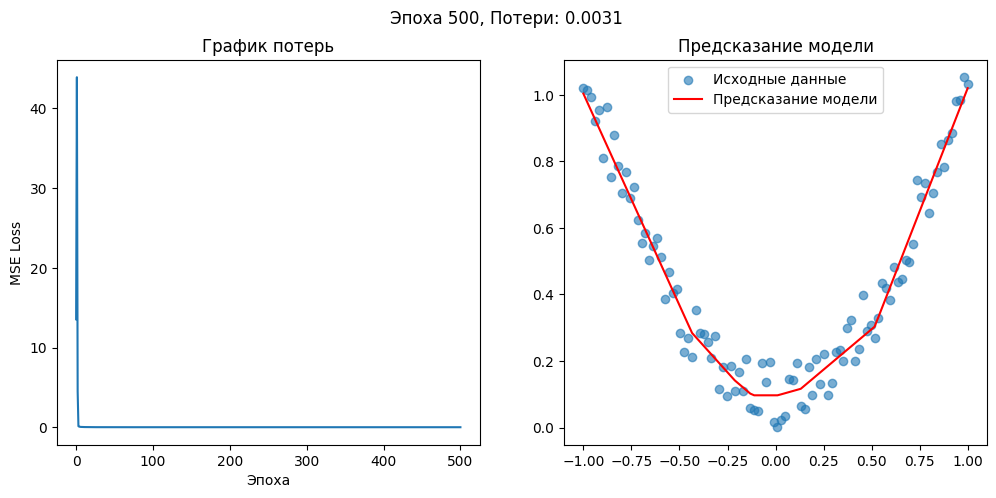

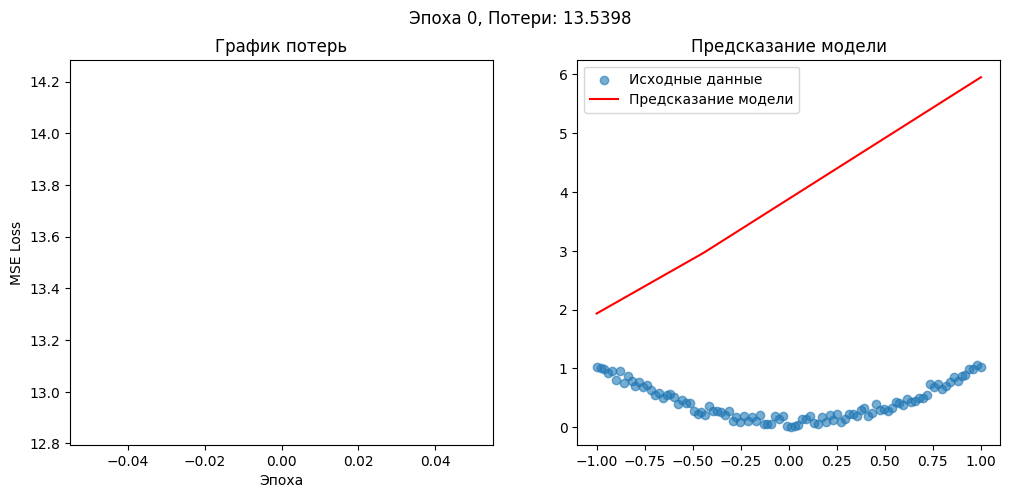

In [62]:
X = th.linspace(-1, 1, 100).view(-1, 1)
y = X.pow(2) + 0.2 * th.rand(X.size())

N_NEURONS_BETWEEN=10
layer1 = Linear(n_features=1, n_neurons=N_NEURONS_BETWEEN, seed=SEED)
activation = ReLU()
layer2 = Linear(n_features=N_NEURONS_BETWEEN, n_neurons=1, seed=SEED)
loss_fn = MSELoss()
LEARNING_RATE = 0.1
N_EPOCHS = 1000
losses = []

for epoch in range(N_EPOCHS+1):
    
    out1 = layer1.forward(X)
    out2 = activation.forward(out1)
    out3 = layer2.forward(out2)
    loss = loss_fn.forward(out3, y)
    losses.append(loss.item())
    
    loss_fn.backward(out3, y)
    layer2.backward(out2, loss_fn.dinput)
    activation.backward(out1, layer2.dinput)
    layer1.backward(X, activation.dinput)
    
    with th.no_grad():
        layer2.weights -= LEARNING_RATE * layer2.dweights
        layer1.weights -= LEARNING_RATE * layer1.dweights

    
    if epoch % 50 == 0:
        clear_output(wait=True)
        
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        if epoch == (N_EPOCHS+1)//2:
            mid_losses = losses.copy()
            mid_out3 = out3
            mid_epoch = epoch
        
        elif epoch == 0:
            start_losses = losses.copy()
            start_out3 = out3
            start_epoch = epoch
            
            
        ax1.plot(losses)
        ax1.set_title("График потерь")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("MSE Loss")

        ax2.scatter(X.numpy(), y.numpy(), label='Исходные данные', alpha=0.6)
        ax2.plot(X.numpy(), out3.detach().numpy(), color='red', label='Предсказание модели')
        ax2.set_title("Предсказание модели")
        ax2.legend()
        
        fig.suptitle(f"Эпоха {epoch}, Потери: {loss.item():.4f}")
        
        plt.show()
        

        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))    
    
ax1.plot(mid_losses)
ax1.set_title("График потерь")
ax1.set_xlabel("Эпоха")
ax1.set_ylabel("MSE Loss")

ax2.scatter(X.numpy(), y.numpy(), label='Исходные данные', alpha=0.6)
ax2.plot(X.numpy(), mid_out3.detach().numpy(), color='red', label='Предсказание модели')
ax2.set_title("Предсказание модели")
ax2.legend()

fig.suptitle(f"Эпоха {mid_epoch}, Потери: {mid_losses[-1]:.4f}")

plt.show()






fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))    
    
ax1.plot(start_losses)
ax1.set_title("График потерь")
ax1.set_xlabel("Эпоха")
ax1.set_ylabel("MSE Loss")

ax2.scatter(X.numpy(), y.numpy(), label='Исходные данные', alpha=0.6)
ax2.plot(X.numpy(), start_out3.detach().numpy(), color='red', label='Предсказание модели')
ax2.set_title("Предсказание модели")
ax2.legend()

fig.suptitle(f"Эпоха {start_epoch}, Потери: {start_losses[-1]:.4f}")

plt.show()